In [11]:
import numpy as np
import pandas as pd
from statsmodels.tsa.tsatools import lagmat
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
# import spearmanr from scipy.stats
from scipy.stats import spearmanr
# load data
horm_beh = np.load('preprocessed_hormones_behavior_last_animal.npy', allow_pickle=True).item()
X1m = horm_beh['X1m'].T
X1a = horm_beh['X1a'].T
X2m = horm_beh['X2m'].T
X2a = horm_beh['X2a'].T
X3 = horm_beh['X3'].T
y1m = horm_beh['y1m']
y1a = horm_beh['y1a']
y2m = horm_beh['y2m']
y2a = horm_beh['y2a']
y3 = horm_beh['y3']
common_comps = horm_beh['common_comps']

In [12]:
# robust z-score for each individual animal first
def robust_zscore(data, axis=0, log_transform=False, exclude_outliers=False, z_transform=False):
    if log_transform:
        data = np.log(data)
    median = np.nanmedian(data, axis=axis)
    mad = np.nanmedian(np.abs(data - median), axis=axis)
    if z_transform:
        zscore = (data - median) / mad
    else:
        zscore = data - median
    if exclude_outliers:
        zscore[np.abs(zscore) > 3] = np.nan
    return zscore

X1 = robust_zscore(np.concatenate([X1m, X1a], axis=0), log_transform=False)
X2 = robust_zscore(np.concatenate([X2m, X2a], axis=0), log_transform=False)
X3 = robust_zscore(X3, log_transform=False)

y1 = np.concatenate([y1m, y1a], axis=0)
y2 = np.concatenate([y2m, y2a], axis=0)
y3 = y3

In [13]:
# concatenate data
X = np.concatenate([X1, X2, X3], axis=0)
y = robust_zscore(np.concatenate([y1m, y1a, y2m, y2a, y3], axis=0), log_transform=True, z_transform=False)
n_samples, n_features = X.shape

In [14]:
# correlate histamine and behavior
from scipy.stats import pearsonr
histamine_idx = common_comps.index('Histamine')
r, p = spearmanr(X[:, histamine_idx], y)
print(f'Correlation between Histamine and Behavior: r={r:.3f}, p={p:.3e}')

Correlation between Histamine and Behavior: r=0.624, p=3.938e-20


In [15]:
max_lag = 5

In [16]:
# spearman R cross correlation
def spearman_ccf(x, y, max_lag):
    lags = np.arange(-max_lag+1, max_lag)
    ccf = [spearmanr(x[max_lag+lag:-max_lag+lag], 
                     y[max_lag: -max_lag])[0] for lag in lags]
    return lags, ccf

<StemContainer object of 3 artists>

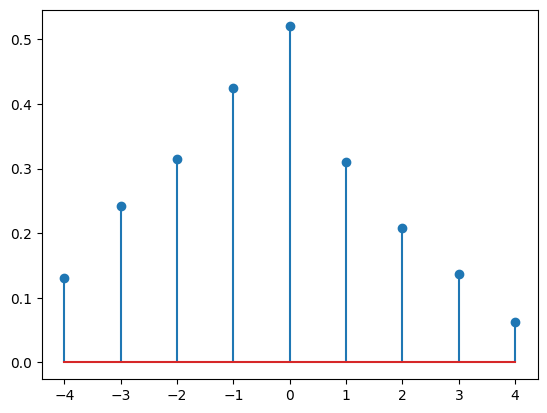

In [17]:
# compute cross correlaiton between histamine and histidine
histidine_idx = common_comps.index('Histidine')
histamine_idx = common_comps.index('Histamine')
lags, ccf_histamine_histidine = spearman_ccf(X[:, histamine_idx], X[:, histidine_idx],max_lag=5)
plt.figure()
plt.stem(lags, ccf_histamine_histidine)

Text(0, 0.5, 'Locomotion')

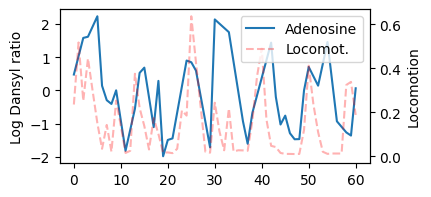

In [18]:
plt.figure(figsize=(4, 2))
adenosine_idx = common_comps.index('Adenosine')
plt.plot(X2[:, adenosine_idx], label='Adenosine')
plt.ylabel('Log Dansyl ratio')
plt.twinx()
plt.plot(0,0,label='Adenosine')
plt.plot(y2, c='red', alpha=0.3, ls='--', label='Locomot.')
plt.legend()
plt.xlabel('Sample # (7.5 min)')
plt.ylabel('Locomotion')
# plt.savefig('adenosine_speed.pdf', dpi=300)

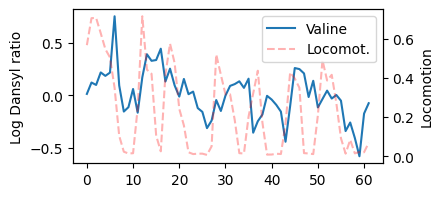

In [25]:
plt.figure(figsize=(4, 2))
creatine_idx = common_comps.index('Valine')
plt.plot(X3[:, creatine_idx], label='Valine')
plt.ylabel('Log Dansyl ratio')
plt.twinx()
plt.plot(0,0,label='Valine')
plt.plot(y3, c='red', alpha=0.3, ls='--', label='Locomot.')
plt.legend()
plt.xlabel('Sample # (7.5 min)')
plt.ylabel('Locomotion')
plt.savefig('valine_speed.pdf', dpi=300)

Text(0, 0.5, 'Locomotion')

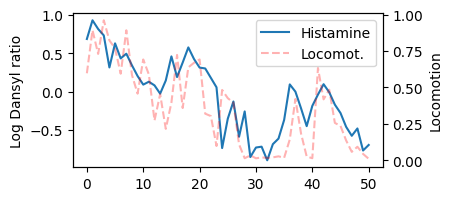

In [9]:
plt.figure(figsize=(4, 2))
histamine_idx = common_comps.index('Histamine')
plt.plot(X1[:, histamine_idx], label='Histamine')
plt.ylabel('Log Dansyl ratio')
plt.twinx()
plt.plot(0,0,label='Histamine')
plt.plot(y1, c='red', alpha=0.3, ls='--', label='Locomot.')
plt.legend()
plt.xlabel('Sample # (7.5 min)')
plt.ylabel('Locomotion')
# plt.savefig('histamine_speed.pdf', dpi=300)

Text(0, 0.5, 'Locomotion')

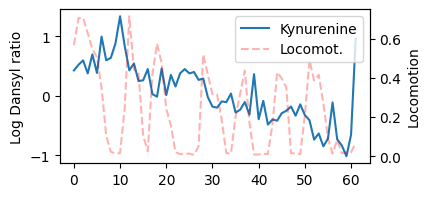

In [10]:
# plot N-formylkynurenine
plt.figure(figsize=(4, 2))
# nfk_idx = common_comps.index('N-formylkynurenine')
nfk_idx = common_comps.index('Kynurenine')
plt.plot(X3[:, nfk_idx], label='Kynurenine')
plt.ylabel('Log Dansyl ratio')
plt.twinx()
plt.plot(0,0,label='Kynurenine')
plt.plot(y3, c='red', alpha=0.3, ls='--', label='Locomot.')
plt.legend()
plt.xlabel('Sample # (7.5 min)')
plt.ylabel('Locomotion')
# plt.savefig('kynurenine_speed.pdf', dpi=300)

In [12]:
def plot_ccf(idx):
    lags, ccf = spearman_ccf(X[:,idx],y,max_lag)
    plt.stem(np.array(lags*7.5), ccf)
    plt.xlabel('Lag (min)')
    plt.ylabel('Spearman R')
    plt.axvline(0, color='k', ls='--')
    plt.title(f'{common_comps[idx]}')

Text(0.5, 1.0, '')

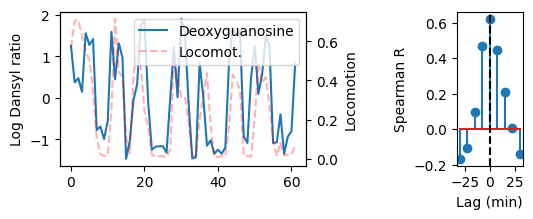

In [13]:
# plot deoxyguanonise
plt.figure(figsize=(7, 2))
plt.subplot(1,2,1)
deoxy_idx = common_comps.index('Deoxyguanosine')
plt.plot(X3[:, deoxy_idx], label='Deoxyguanosine')
plt.ylabel('Log Dansyl ratio')
plt.twinx()
plt.plot(0,0,label='Deoxyguanosine')
plt.plot(y3, c='red', alpha=0.3, ls='--', label='Locomot.')
plt.legend()
plt.xlabel('Sample # (7.5 min)')
plt.ylabel('Locomotion')
plt.subplot(176)
plot_ccf(deoxy_idx)
plt.title('')
# plt.tight_layout()

Text(0.5, 1.0, '')

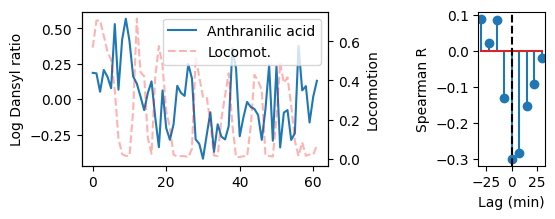

In [14]:
# plot anthranilic acid
plt.figure(figsize=(7, 2))
plt.subplot(1,2,1)
anthr_idx = common_comps.index('Anthranilic acid')
plt.plot(X3[:, anthr_idx], label='Anthranilic acid')
plt.ylabel('Log Dansyl ratio')
plt.twinx()
plt.plot(0,0,label='Anthranilic acid')
plt.plot(y3, c='red', alpha=0.3, ls='--', label='Locomot.')
plt.legend()
plt.xlabel('Sample # (7.5 min)')
plt.ylabel('Locomotion')
plt.subplot(176)
plot_ccf(anthr_idx)
plt.title('')
# plt.savefig('anthranilic_acid_speed.pdf', dpi=300)

Text(0.5, 1.0, '')

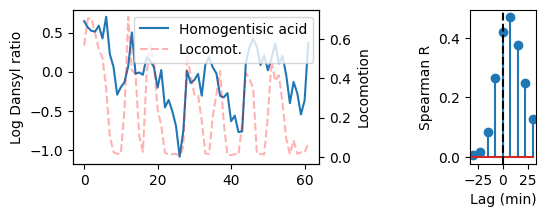

In [15]:
# homogentistic acid
plt.figure(figsize=(7, 2))
plt.subplot(1,2,1)
hga_idx = common_comps.index('Homogentisic acid')
plt.plot(X3[:, hga_idx], label='Homogentisic acid')
plt.ylabel('Log Dansyl ratio')
plt.twinx()
plt.plot(0,0,label='Homogentisic acid')
plt.plot(y3, c='red', alpha=0.3, ls='--',   label='Locomot.')
plt.legend()
plt.xlabel('Sample # (7.5 min)')
plt.ylabel('Locomotion')
plt.subplot(176)
plot_ccf(hga_idx)
plt.title('')
# plt.savefig('homogentisic_acid_speed.pdf', dpi=300)

In [16]:
max_lag = 8

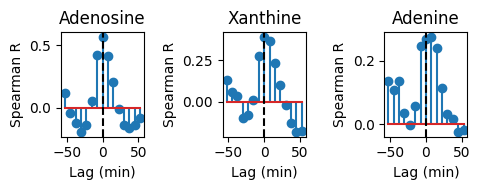

In [17]:
# plot cross correlogram of xhantine, adenosine, and adenine with behavior
plt.figure(figsize=(5, 2))
plt.subplot(131)
adenosine_idx = common_comps.index('Adenosine')
plot_ccf(adenosine_idx)
plt.subplot(132)
xanthine_idx = common_comps.index('Xanthine')
plot_ccf(xanthine_idx)
plt.subplot(133)
adenine_idx = common_comps.index('Adenine')
plot_ccf(adenine_idx)
plt.tight_layout()
# plt.savefig('purines_speed_ccf.pdf', dpi=300)
plt.show()

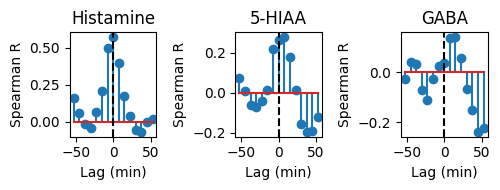

In [18]:
# plot cross_corr of serotonin, histamine, and 5hiaa 
plt.figure(figsize=(5, 2))
plt.subplot(131)
serotonin_idx = common_comps.index('Histamine')
plot_ccf(serotonin_idx)
plt.subplot(132)
histamine_idx = common_comps.index('5-Hydroxyindoleacetic acid')
plot_ccf(histamine_idx)
plt.title('5-HIAA')
plt.subplot(133)
five_hiaa_idx = common_comps.index('gamma-Aminobutyric acid')
plot_ccf(five_hiaa_idx)
plt.title('GABA')
plt.tight_layout()
# plt.savefig('histamine_5hiaa_gaba_ccf.pdf', dpi=300)
plt.show()

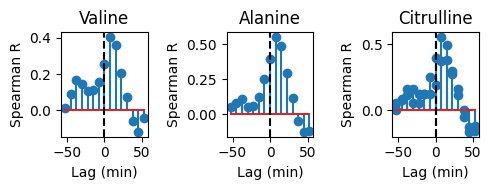

In [19]:
# plot cross corr for valine, alanine, citrulline
plt.figure(figsize=(5, 2))
plt.subplot(131)
valine_idx = common_comps.index('Valine')
plot_ccf(valine_idx)
plt.subplot(132)
isoleucine_idx = common_comps.index('Alanine')
plot_ccf(isoleucine_idx)
plt.subplot(133)
alanine_idx = common_comps.index('Alanine')
plot_ccf(alanine_idx)
plt.subplot(133)
citrulline_idx = common_comps.index('Citrulline')
plot_ccf(citrulline_idx)
plt.tight_layout()
# plt.savefig('val_ala_cit_ccf.pdf', dpi=300)
plt.show()

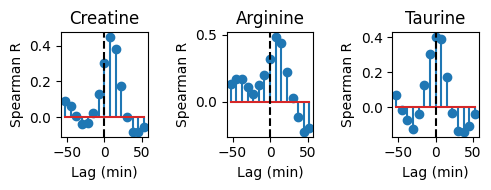

In [20]:
# creatine, arginine, and taurine
plt.figure(figsize=(5, 2))
plt.subplot(131)
creatine_idx = common_comps.index('Creatine')
plot_ccf(creatine_idx)
plt.subplot(132)
arginine_idx = common_comps.index('Arginine')
plot_ccf(arginine_idx)
plt.subplot(133)
taurine_idx = common_comps.index('Taurine')
plot_ccf(taurine_idx)
plt.tight_layout()
# plt.savefig('creatine_arginine_taurine_ccf.pdf', dpi=300)
plt.show()

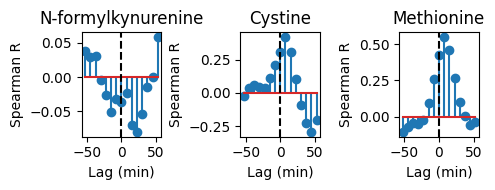

In [21]:
# n formyl kynurenine, cystine, methionine
plt.figure(figsize=(5, 2))
plt.subplot(131)
nformylkynurenine_idx = common_comps.index('N-formylkynurenine')
plot_ccf(nformylkynurenine_idx)
plt.subplot(132)
cystine_idx = common_comps.index('Cystine')
plot_ccf(cystine_idx)
plt.subplot(133)
methionine_idx = common_comps.index('Methionine')
plot_ccf(methionine_idx)
plt.tight_layout()
# plt.savefig('nformylkynurenine_cystine_methionine_ccf.pdf', dpi=300)
plt.show()

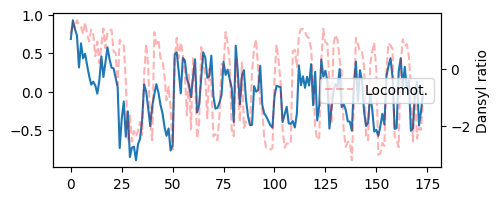

<Figure size 640x480 with 0 Axes>

In [22]:
plt.figure(figsize=(5, 2))
histamine_idx = common_comps.index('Histamine')
plt.plot(X[:, histamine_idx], label='Histamine')
plt.twinx()
plt.plot(y,c='red',alpha=0.3, ls='--',label='Locomot.')
plt.legend()
plt.xlabel('Sample # (7.5 min)')
plt.ylabel('Dansyl ratio')
# plt.savefig('histamine_speed.pdf', dpi=300)
plt.show()
plt.tight_layout()

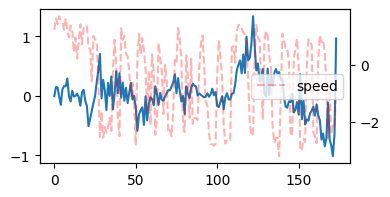

In [23]:
plt.figure(figsize=(4, 2))
kynurenine_idx = common_comps.index('Kynurenine')
plt.plot(X[:, kynurenine_idx], label='Kynurenine')
plt.twinx()
plt.plot(y, c='red', alpha=0.3, ls='--', label='speed')
plt.legend()

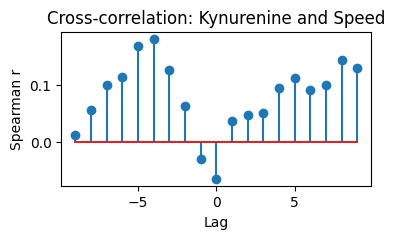

In [24]:
# plot cross correlation of kynurenine and speed
lags, ccf = spearman_ccf(X[:, kynurenine_idx], y, max_lag=10)
plt.figure(figsize=(4, 2))
plt.stem(lags, ccf)
plt.xlabel('Lag')
plt.ylabel('Spearman r')
plt.title('Cross-correlation: Kynurenine and Speed')
# plt.savefig('kynurenine_speed_ccf.pdf', dpi=300)
plt.show()

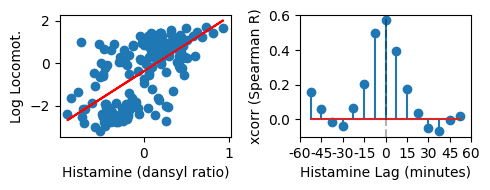

In [25]:

plt.figure(figsize=(5, 2))
plt.subplot(121)
plt.scatter(X[:, histamine_idx], y)
# add regression line
m, b = np.polyfit(X[:, histamine_idx], y, 1)
plt.plot(X[:, histamine_idx], m*X[:, histamine_idx] + b, color='red')
plt.xlabel('Histamine (dansyl ratio)')
plt.ylabel('Log Locomot.')

plt.subplot(122)
# plt.xcorr(np.log(X[:, histamine_idx]), np.log(y),maxlags=8)
lags, rs = spearman_ccf(X[:, histamine_idx], y, max_lag=8)
plt.stem(lags, rs)
plt.axvline(0, color='k', linestyle='--',alpha=0.3)
plt.xticks(np.arange(-8, 9, 2), labels=(np.arange(-8, 9, 2)*7.5).astype(int))   
plt.xlabel('Histamine Lag (minutes)')
plt.ylabel('xcorr (Spearman R)')
plt.tight_layout()
# plt.savefig('histamine_lagged_corr.pdf', dpi=300)

Correlation between Creatine and Behavior: r=0.284, p=1.473e-04


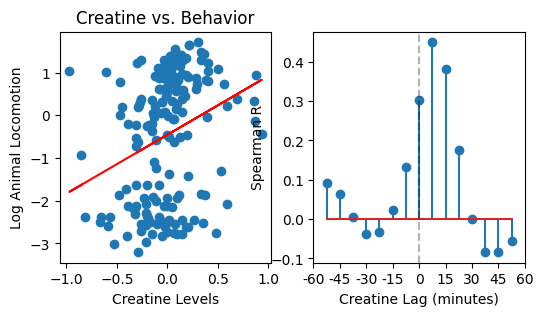

In [26]:
# scatter creatine and behavior
creatine_idx = common_comps.index('Creatine')
r, p = pearsonr(X[:, creatine_idx], y)
print(f'Correlation between Creatine and Behavior: r={r:.3f}, p={p:.3e}')
plt.figure(figsize=(6, 3))

plt.subplot(121)
plt.scatter(X[:, creatine_idx], y)
# add regression line
m, b = np.polyfit(X[:, creatine_idx], y, 1)
plt.plot(X[:, creatine_idx], m*X[:, creatine_idx] + b, color='red')
plt.xlabel('Creatine Levels')
plt.ylabel('Log Animal Locomotion')
plt.title('Creatine vs. Behavior')

plt.subplot(122)
# cross-correlation of histamine with behavior
maxlag = 8
# plt.xcorr(np.log(X[:, creatine_idx]), np.log(y), maxlags=maxlag)
lags, rs = spearman_ccf(X[:, creatine_idx], y, max_lag=8)
plt.stem(lags, rs)
plt.xticks(np.arange(-maxlag, maxlag + 1, 2), labels=(np.arange(-maxlag, maxlag + 1, 2)*7.5).astype(int))   
plt.xlabel('Creatine Lag (minutes)')
plt.ylabel('Spearman R')
plt.axvline(0, color='k', linestyle='--',alpha=0.3)
plt.show()

Correlation between Kynurenine and Behavior: r=-0.008, p=9.172e-01


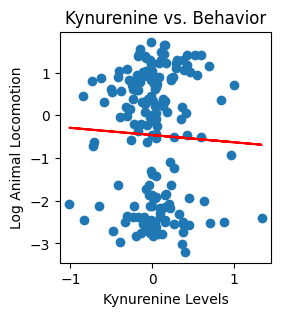

In [27]:
# kynurenine
kynurenine_idx = common_comps.index('Kynurenine')
r, p = spearmanr(X[:, kynurenine_idx], y)
print(f'Correlation between Kynurenine and Behavior: r={r:.3f}, p={p:.3e}')
plt.figure(figsize=(6, 3))
plt.subplot(121)
plt.scatter(X[:, kynurenine_idx], y)
# add regression line
m, b = np.polyfit(X[:, kynurenine_idx], y, 1)
plt.plot(X[:, kynurenine_idx], m*X[:, kynurenine_idx] + b, color='red')
plt.xlabel('Kynurenine Levels')
plt.ylabel('Log Animal Locomotion')
plt.title('Kynurenine vs. Behavior')

# plt.subplot(122)
# # cross-correlation of kynurenine with behavior
# maxlag = 8
# # plt.xcorr(np.log(X[:, taurine_idx]), np.log(y), maxlags=maxlag)
# lags, rs = spearman_ccf(X[:, kynurenine_idx], y, max_lag=8)
# plt.stem(lags, rs)
# plt.xticks(np.arange(-maxlag, maxlag + 1, 2), labels=(np.arange(-maxlag, maxlag + 1, 2)*7.5).astype(int))   
# plt.xlabel('Kynurenine Lag (minutes)')
# plt.ylabel('Spearman R')
# plt.axvline(0, color='k', linestyle='--',alpha=0.3)
plt.show()

In [26]:
# compute all ccgs
all_ccgs = {}
for i, comp in enumerate(common_comps):
    lags, rs = spearman_ccf(X[:, i], y, max_lag=8)
    all_ccgs[comp] = (lags, rs)

In [27]:
common_comps

['(2R,4S)-2,4-Diaminopentanoic acid',
 '(R)-1-Aminopropan-2-ol',
 '1,2-Dihydroxynaphthalene-6-sulfonic acid',
 '1-Aminocyclopropane-1-carboxylic acid',
 '1-Methylhistidine',
 '2,6-Dihydroxypyridine',
 '2,8-Dihydroxyadenine',
 '2-Amino-4-chloro-4-pentenoic acid',
 '2-Aminobutyric acid/2-Aminoisobutyric acid/3-Aminoisobutyric acid',
 '2-Aminooctanoic acid',
 '2-Hydroxy-cis-hex-2,4-dienoic acid',
 '2-Hydroxyethylenedicarboxylic acid',
 '2-Isopropoxyphenol',
 '3-(4-Hydroxyphenyl)lactic acid',
 '3-Amino-2-piperidone',
 '3-Aminoisobutyric acid',
 '3-Aminopropanal',
 '3-Cyano-L-alanine',
 '3-Hydroxy-L-proline',
 '3-Hydroxybenzaldehyde',
 '3-Methoxy-4-hydroxyphenylacetaldehyde',
 '3-Methylsalicylaldehyde',
 '3-Nitrotyrosine',
 '4,8-Dihydroxyquinoline',
 '4-Amino-2-hydroxylamino-6-nitrotoluene',
 '4-Amino-4-deoxychorismic acid',
 '4-Aminobutyraldehyde',
 '4-Chloro-L-lysine',
 '4-Cresol/3-Cresol',
 '4-Ethylphenol',
 '4-Guanidinobutanal',
 '4-Hydroxyaniline',
 '4-Hydroxybenzaldehyde/3-Hydroxybenz

(array([ 5.,  5.,  9., 10.,  2.,  0., 21., 37., 41., 25.]),
 array([-0.61112315, -0.48794212, -0.36476109, -0.24158005, -0.11839902,
         0.00478202,  0.12796305,  0.25114409,  0.37432512,  0.49750616,
         0.62068719]),
 <BarContainer object of 10 artists>)

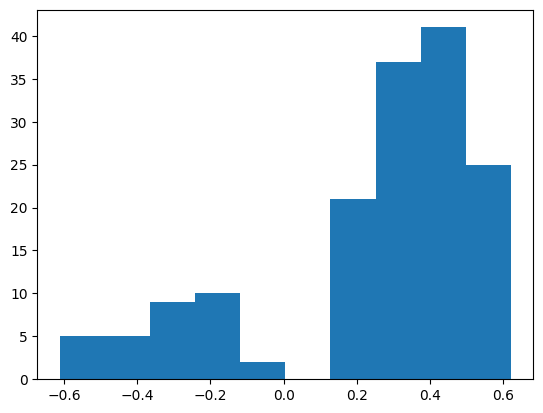

In [31]:
plt.hist([all_ccgs[c][1][np.argmax(np.abs(all_ccgs[c][1]))] for c in common_comps])

In [40]:
np.sum([all_ccgs[c][1][np.argmax(np.abs(all_ccgs[c][1]))] <-0.2  for c in common_comps]),np.sum([all_ccgs[c][1][np.argmax(np.abs(all_ccgs[c][1]))] >0.2  for c in common_comps])

(np.int64(25), np.int64(115))

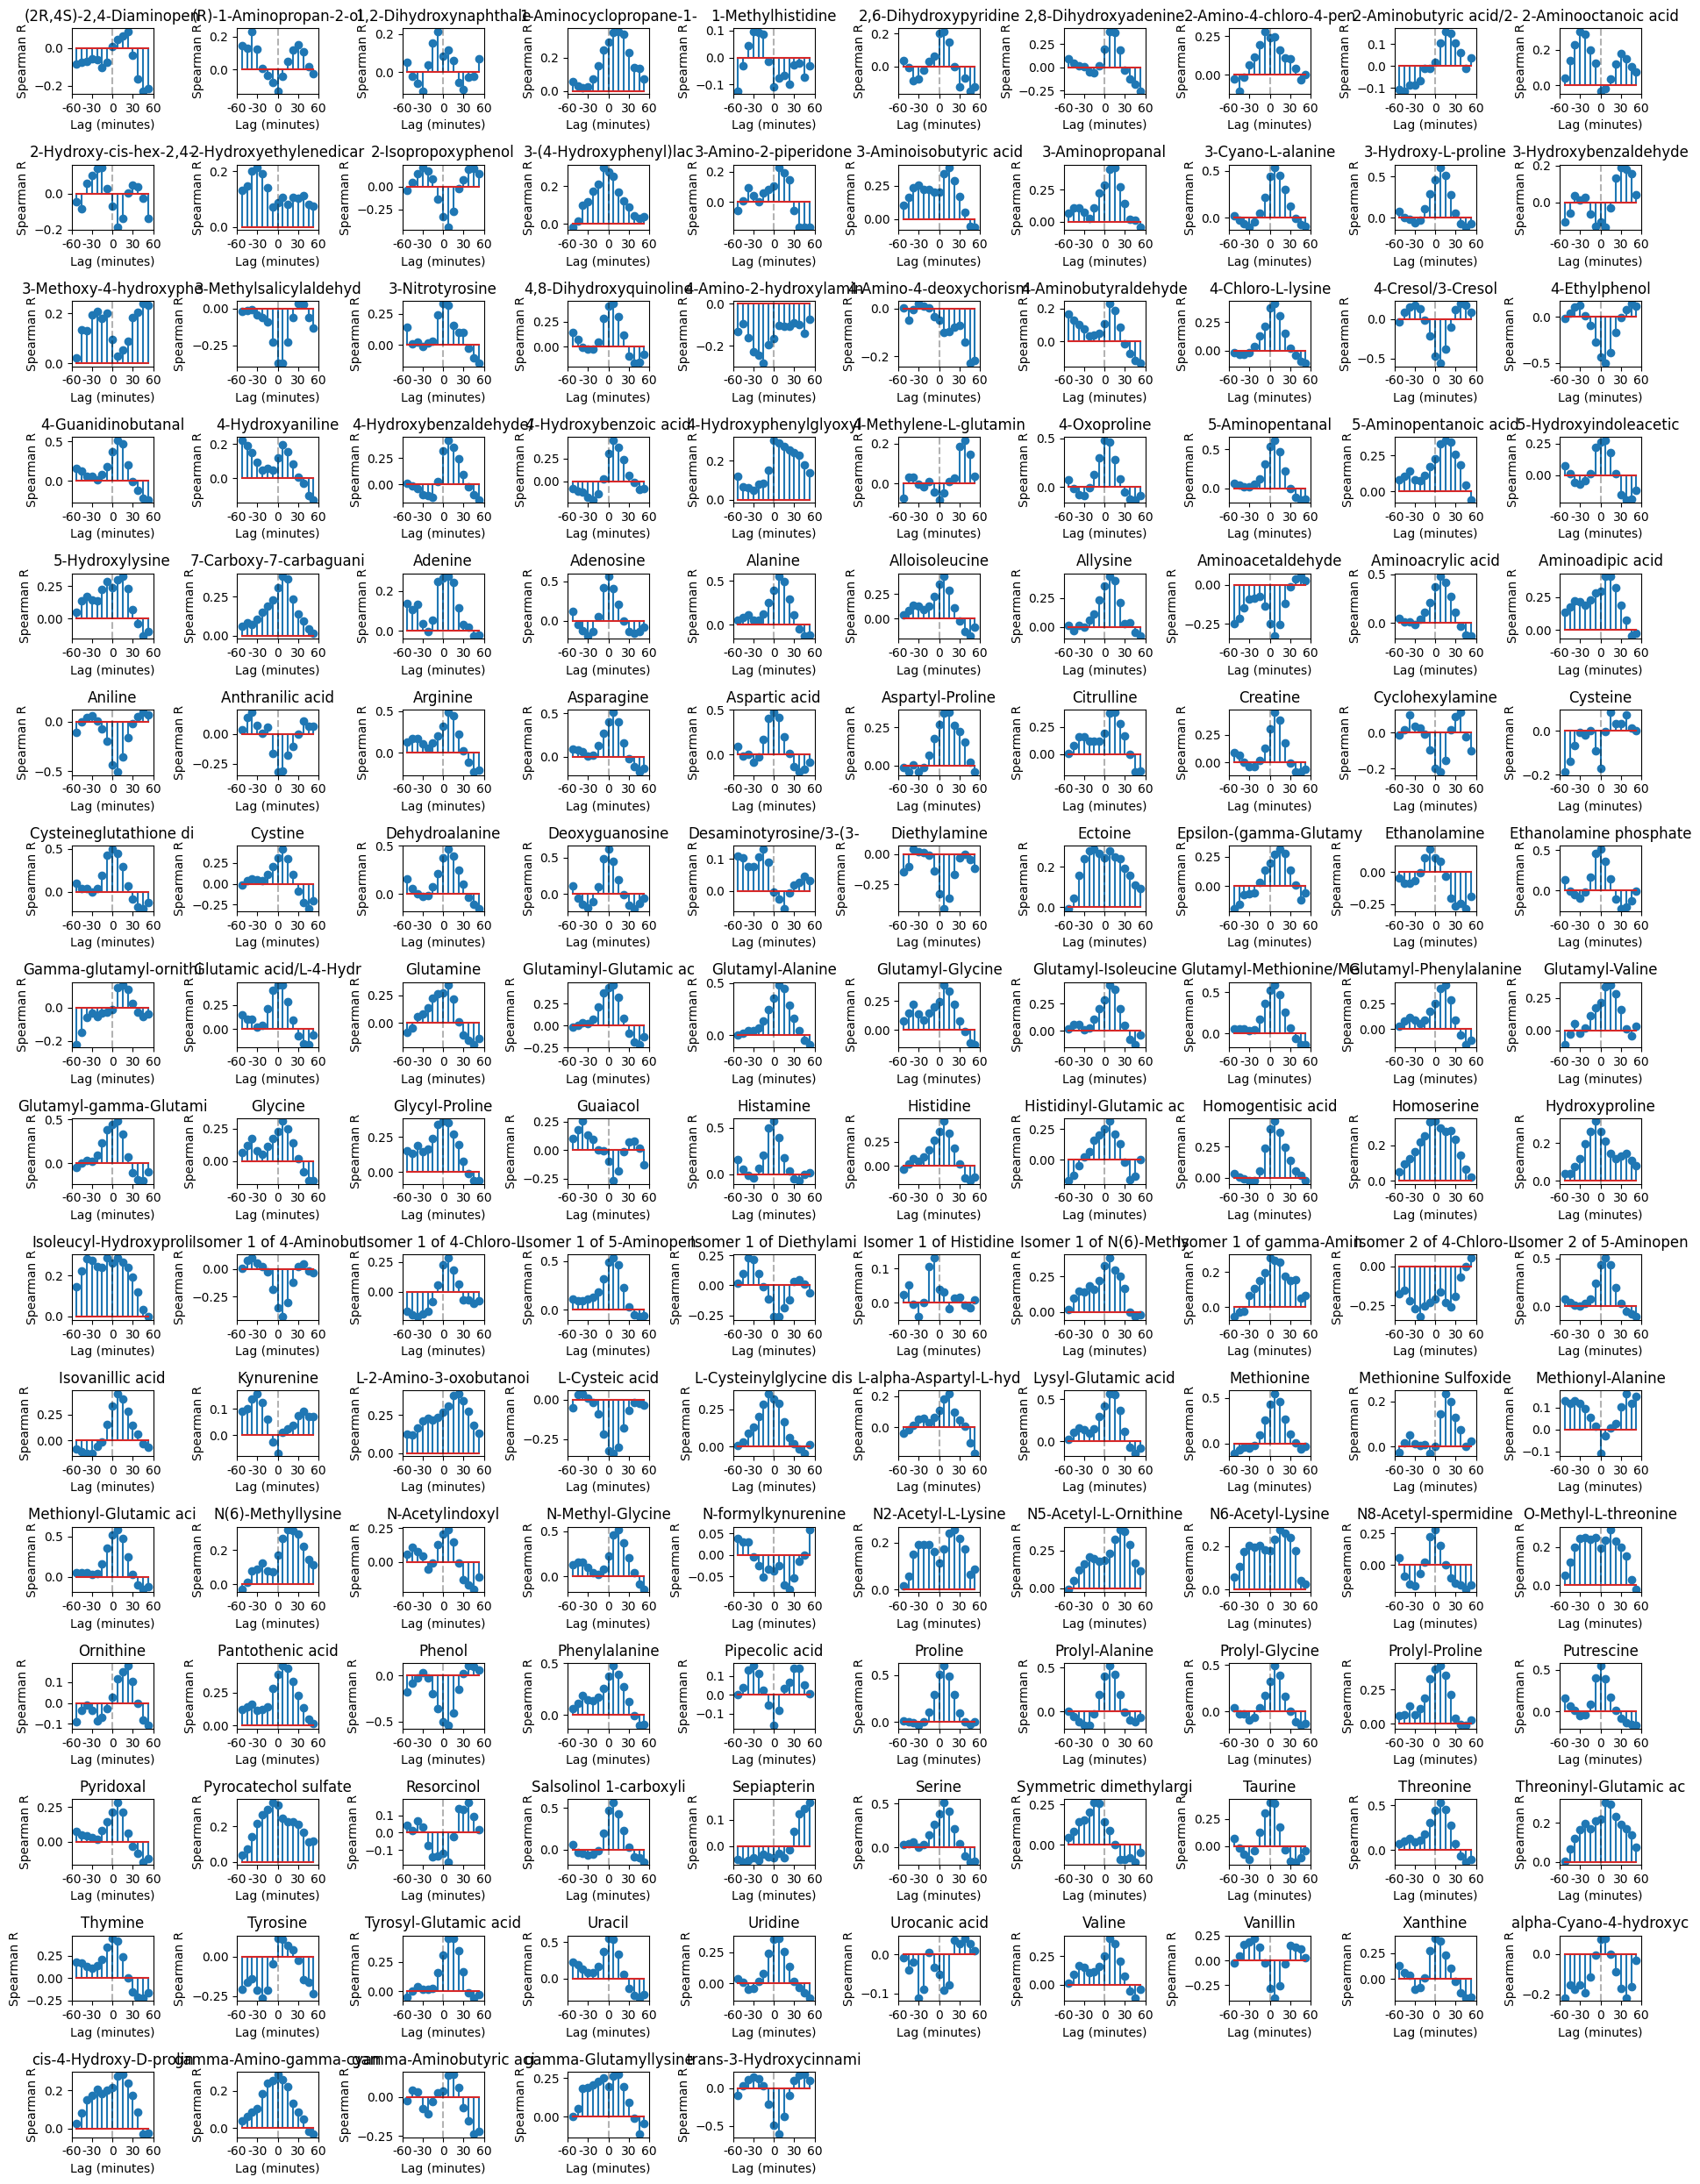

In [30]:
# plot all the spearman cross-correlations
plt.figure(figsize=(19  , 25))
for i, comp in enumerate(common_comps):
    plt.subplot(16, 10, i+1)
    lags, rs = all_ccgs[comp]
    plt.stem(lags, rs)
    plt.xticks(np.arange(-8, 9, 4), labels=(np.arange(-8, 9, 4)*7.5).astype(int))   
    plt.xlabel('Lag (minutes)')
    plt.ylabel('Spearman R')
    plt.title(comp[:22])
    plt.axvline(0, color='k', linestyle='--',alpha=0.3)
plt.tight_layout()
plt.show()

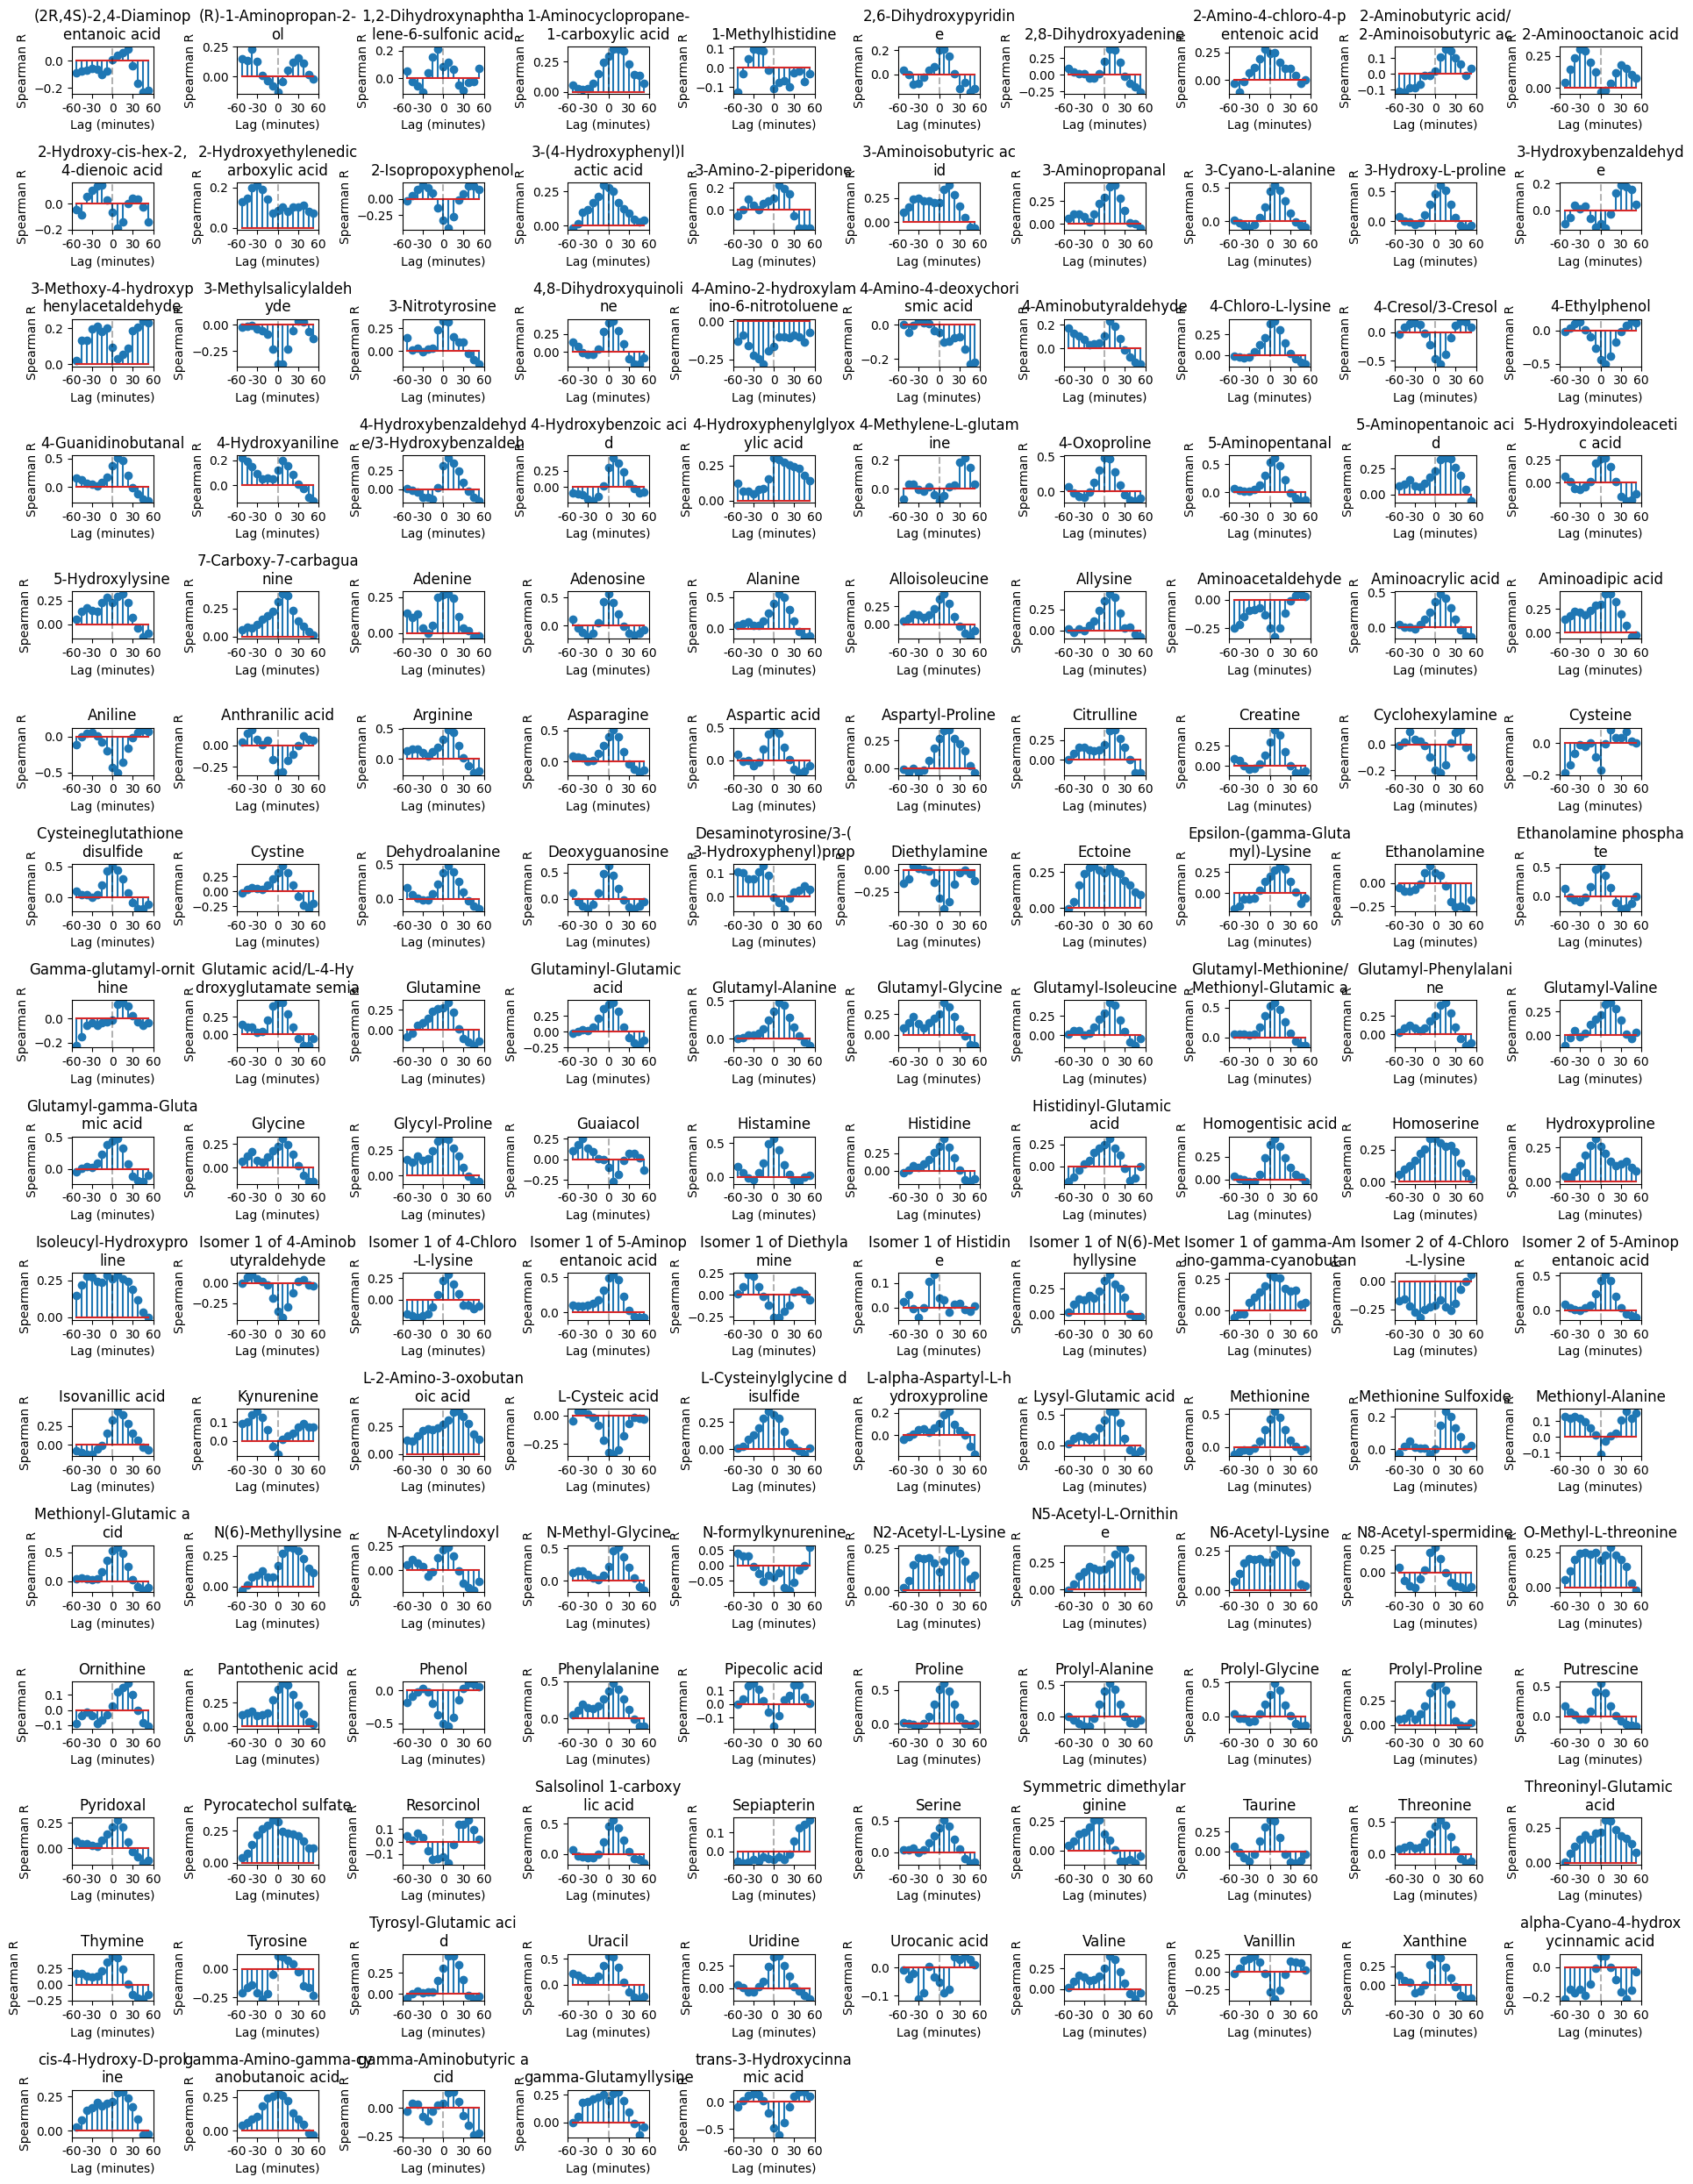

In [ ]:
# plot all the spearman cross-correlations
plt.figure(figsize=(19  , 25))
for i, comp in enumerate(common_comps):
    plt.subplot(16, 10, i+1)
    lags, rs = all_ccgs[comp]
    plt.stem(lags, rs)
    plt.xticks(np.arange(-8, 9, 4), labels=(np.arange(-8, 9, 4)*7.5).astype(int))   
    plt.xlabel('Lag (minutes)')
    plt.ylabel('Spearman R')
    if len(comp) > 20:
        plt.title(comp[:20] + '\n' + comp[20:40])
    else:
        plt.title(comp)
    plt.axvline(0, color='k', linestyle='--',alpha=0.3)
plt.tight_layout()
# plt.savefig('all_compound_speed_ccf.svg',dpi=300)
plt.show()

In [ ]:
# Arginine Citrulline Xanthine (1 delay)

# Adenosine Histamine (no delay)

# anything -1?? (Kynurenine)

# 2 delays: Isomer 2 of 5-Aminopentanoic acid

In [1]:
common_comps

NameError: name 'common_comps' is not defined

Correlation between Serotonin and Behavior: r=-0.144, p=5.759e-02


/tmp/ipykernel_101378/68525931.py:7: RuntimeWarning: divide by zero encountered in log
  plt.scatter(np.log(X[:, serotonin_idx]), np.log(y))
/tmp/ipykernel_101378/68525931.py:7: RuntimeWarning: invalid value encountered in log
  plt.scatter(np.log(X[:, serotonin_idx]), np.log(y))
/tmp/ipykernel_101378/68525931.py:18: RuntimeWarning: divide by zero encountered in log
  plt.xcorr(np.log(X[:, serotonin_idx]), np.log(y), maxlags=maxlag)
/tmp/ipykernel_101378/68525931.py:18: RuntimeWarning: invalid value encountered in log
  plt.xcorr(np.log(X[:, serotonin_idx]), np.log(y), maxlags=maxlag)


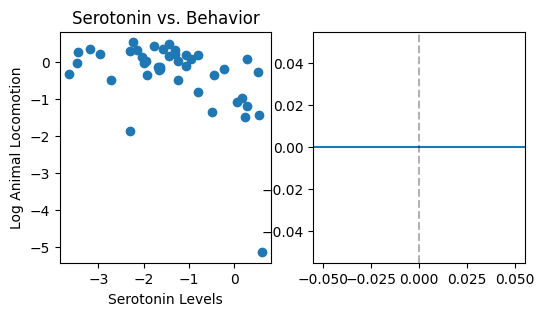

In [35]:
# serotonin
serotonin_idx = common_comps.index('Resorcinol')
r, p = pearsonr(X[:, serotonin_idx], y)
print(f'Correlation between Serotonin and Behavior: r={r:.3f}, p={p:.3e}')
plt.figure(figsize=(6, 3))
plt.subplot(121)
plt.scatter(np.log(X[:, serotonin_idx]), np.log(y))
# add regression line
m, b = np.polyfit(X[:, serotonin_idx], y, 1)
# plt.plot(X[:, serotonin_idx], m*X[:, serotonin_idx] + b, color='red')
plt.xlabel('Serotonin Levels')
plt.ylabel('Log Animal Locomotion')
plt.title('Serotonin vs. Behavior') 

plt.subplot(122)
# cross-correlation of serotonin with behavior
maxlag = 8
plt.xcorr(np.log(X[:, serotonin_idx]), np.log(y), maxlags=maxlag)
plt.axvline(0, color='k', linestyle='--',alpha=0.3)
plt.show()  

# run vs sleep hormones

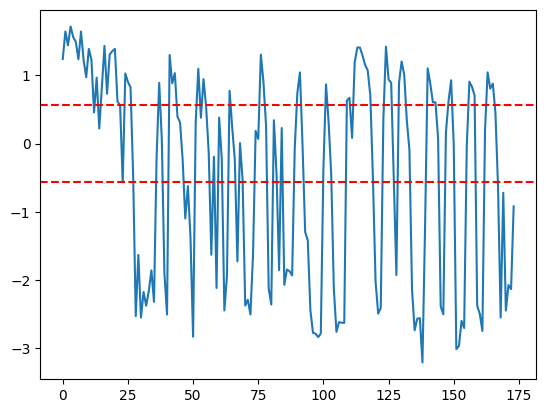

In [36]:
plt.plot(y)
y_med = np.median(y)
y_abd = np.median(np.abs(y - y_med))
plt.axhline(y_med - y_abd/2, color='r', linestyle='--')
plt.axhline(y_med + y_abd/2, color='r', linestyle='--')

In [37]:
from scipy.ndimage import label

In [38]:
# take periods where y is above median for more than one lag
above_med = y > y_med
# find contiguous regions where above_med is True
labeled, n_labels = label(above_med)
# find lengths of each labeled region
lengths = np.bincount(labeled)[1:]  # skip background count at index 0
# find labels of regions longer than 1 lag
long_labels = np.where(lengths > 2)[0] + 1  # skip background label 0
# create mask for long regions
mask_run = np.isin(labeled, long_labels)

# take periods where y is below median for more than one lag
below_med = y < y_med - y_abd/2
# find contiguous regions where below_med is True
labeled, n_labels = label(below_med)
# find lengths of each labeled region
lengths = np.bincount(labeled)[1:]  # skip background count at index 0
# find labels of regions longer than 1 lag
long_labels = np.where(lengths > 2)[0] + 1  # skip background label 0
# create mask for long regions
mask_sleep = np.isin(labeled, long_labels)

In [39]:
labeled

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  2,  2,  2,  2,  2,  2,
        2,  2,  0,  0,  0,  3,  3,  0,  0,  0,  0,  0,  0,  4,  4,  4,  4,
        0,  0,  0,  0,  0,  0,  5,  0,  6,  0,  0,  7,  7,  0,  0,  0,  8,
        0,  0,  9,  9,  9,  9,  0,  0,  0,  0,  0, 10, 10,  0,  0, 11,  0,
       12, 12, 12, 12,  0,  0,  0,  0, 13, 13, 13, 13, 13, 13, 13,  0,  0,
        0,  0, 14, 14, 14, 14, 14,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0, 15, 15, 15,  0,  0,  0,  0,  0, 16,  0,  0,  0,  0,  0, 17, 17,
       17, 17, 17, 17,  0,  0,  0,  0,  0, 18, 18,  0,  0,  0,  0, 19, 19,
       19, 19,  0,  0,  0,  0, 20, 20, 20,  0,  0,  0,  0,  0, 21, 21, 21,
       21, 21, 21, 21], dtype=int32)

In [40]:
long_labels

array([ 2,  4,  9, 12, 13, 14, 15, 17, 19, 20, 21])

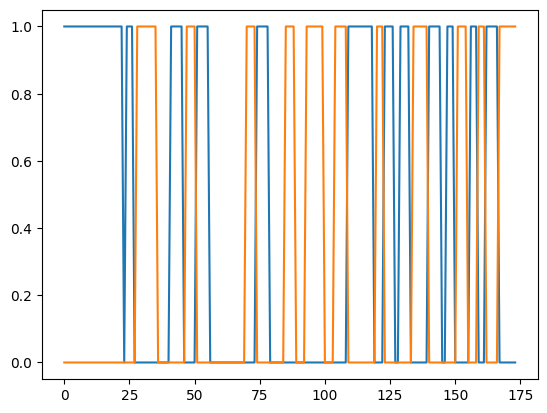

In [41]:
plt.plot(mask_run)
plt.plot(mask_sleep)

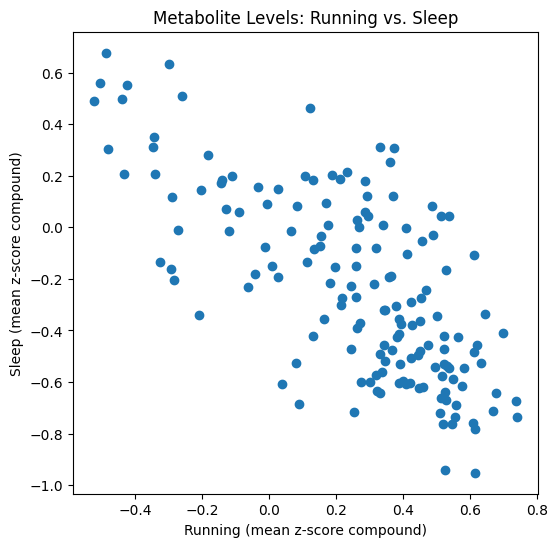

In [52]:
# zscore each row of X
X_z = (X - X.mean(axis=0)) / X.std(axis=0)
X_run = X_z[mask_run]
X_sleep = X_z[mask_sleep]
X_run_mean = np.median(X_run, axis=0)
X_sleep_mean = np.median(X_sleep, axis=0)
# plot run vs sleep means
plt.figure(figsize=(6, 6))
plt.scatter(X_run_mean, X_sleep_mean)
plt.xlabel('Running (mean z-score compound)')
plt.ylabel('Sleep (mean z-score compound)')
plt.title('Metabolite Levels: Running vs. Sleep')
plt.savefig('run_vs_sleep_metabolites.svg', dpi=300)

In [55]:
# extract the 5 ones that are highest in run and lowest in sleep
diff = X_run_mean - X_sleep_mean
top5_run = np.argsort(diff)[-5:]
top5_sleep = np.argsort(diff)[:5]
# plot compound names
np.array(common_comps)[top5_run], np.array(common_comps)[top5_sleep]

top5_run = np.argsort(diff)[-20:]
top5_sleep = np.argsort(diff)[:20]
# plot compound names (reverse order)
np.array(common_comps)[top5_run][::-1], np.array(common_comps)[top5_sleep][::-1]

(array(['Histamine', '5-Aminopentanal', 'Deoxyguanosine',
        'Glutamyl-Methionine/Methionyl-Glutamic acid',
        '3-Hydroxy-L-proline', 'Proline', 'Uracil',
        'Methionyl-Glutamic acid', 'Salsolinol 1-carboxylic acid',
        'Isomer 2 of 5-Aminopentanoic acid', 'Arginine',
        '4-Guanidinobutanal', 'Cysteineglutathione disulfide',
        'Asparagine', 'Isomer 1 of 5-Aminopentanoic acid',
        'Ethanolamine phosphate', 'Prolyl-Alanine', 'Alanine', 'Threonine',
        'Thymine'], dtype='<U65'),
 array(['4-Amino-2-hydroxylamino-6-nitrotoluene', 'Guaiacol',
        '1-Methylhistidine', 'Sepiapterin', 'Phenol',
        '3-Hydroxybenzaldehyde', 'Isomer 2 of 4-Chloro-L-lysine',
        'Vanillin', 'Cyclohexylamine', 'Isomer 1 of 4-Aminobutyraldehyde',
        'Diethylamine', 'Anthranilic acid', 'L-Cysteic acid',
        '3-Methylsalicylaldehyde', '2-Isopropoxyphenol',
        'Isomer 1 of Diethylamine', '4-Ethylphenol', 'Aniline',
        '4-Cresol/3-Cresol', 'trans-3-

In [43]:
# indices of 5-HIAA, serotonin, histamine, taurine, and kynurenine
indices = np.array([common_comps.index(comp) for comp in ['5-Hydroxyindoleacetic acid', 'Resorcinol', 'Histamine', 'Taurine', 'Kynurenine']])

In [44]:
indices

array([ 39, 132,  84, 137, 101])

Text(0.5, 1.0, 'Metabolite Levels: Running vs. Sleep')

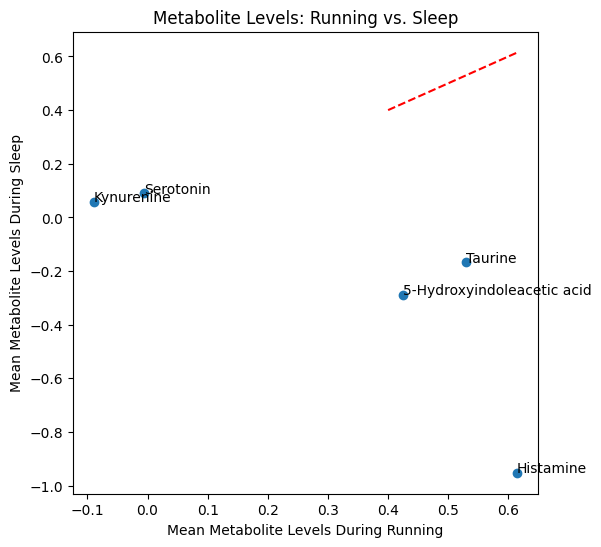

In [45]:
# take average of 5-HIAA, serotonin, histamine, taurine, and kynurenine during run and sleep
X_run = X_z[mask_run][:,indices]
X_sleep = X_z[mask_sleep][:,indices]
X_run_mean = np.median(X_run, axis=0)
X_sleep_mean = np.median(X_sleep, axis=0)
# plot run vs sleep means
plt.figure(figsize=(6, 6))
plt.scatter(X_run_mean, X_sleep_mean)
# plot diagonal line
plt.plot([0.4, np.max(X_run_mean)], [0.4, np.max(X_run_mean)], color='red', linestyle='--')
# label points with compound names
for i, comp in enumerate(['5-Hydroxyindoleacetic acid', 'Serotonin', 'Histamine', 'Taurine', 'Kynurenine']):
    plt.text(X_run_mean[i], X_sleep_mean[i], comp)
plt.xlabel('Mean Metabolite Levels During Running')
plt.ylabel('Mean Metabolite Levels During Sleep')
plt.title('Metabolite Levels: Running vs. Sleep')

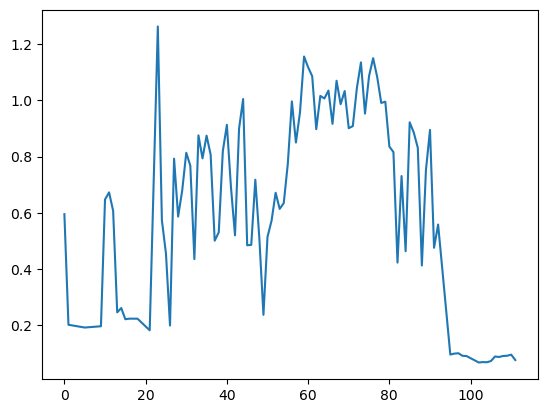

In [71]:
# plot uridine
uridine_idx = common_comps.index('Ornithine')
plt.plot(X[:, uridine_idx])

In [72]:
np.median(X[mask_run, uridine_idx]), np.median(X[mask_sleep, uridine_idx])

(np.float64(0.35760000000000003), np.float64(0.510275))

In [83]:
# extract times when the animal munches, and compute a peri-m,unch time histogram of a bunch of hormones (yeah maybe start with uridine or other things like phenols etc)
anim1_starts = ['9:38am', '2:12pm']
anim1_food_times = [['10:30am', '11:10am', '11:40am', '12:10pm'],['2:20pm', '2:50pm', '3:47pm', '4:38pm','5:18pm']]
anim2_starts = ['9:15am', '2:30pm']
anim2_food_times = [['9:20am','9:35am', '11:00am','12:15pm'],['3:34pm','3:36pm','3:37pm','3:44pm','3:52pm', '5:00pm','5:03pm','5:05pm','5:13pm']]

# turn into pandas datetime
import pandas as pd
anim1_food_times = [[pd.to_datetime(t, format='%I:%M%p') for t in sublist] for sublist in anim1_food_times ]
anim1_starts = pd.to_datetime(anim1_starts, format='%I:%M%p')
anim2_starts = pd.to_datetime(anim2_starts, format='%I:%M%p')
anim2_food_times = [[pd.to_datetime(t, format='%I:%M%p') for t in sublist] for sublist in anim2_food_times]

In [90]:
deltas_anim1 = [[(aft - anim1_starts[i]).seconds/450 for aft in anim1_food_times[i]] for i in range(len(anim1_starts))]
deltas_anim2 = [[(aft - anim2_starts[i]).seconds/450 for aft in anim2_food_times[i]] for i in range(len(anim2_starts))]

In [97]:
def z_score_rows(mat):
    abs_dev = np.median(np.abs(mat - np.median(mat, axis=0)), axis=0)
    return (mat - np.median(mat, axis=0)) / abs_dev

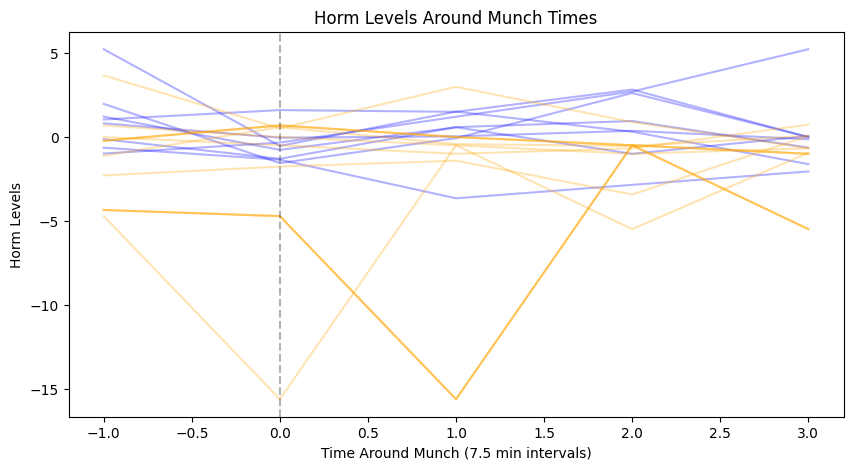

In [100]:
# take X1a, X1m, X2a, X2m and check the hormone levels at those times +/- 1 lag (7.5 minutes)
X1 = [z_score_rows(X1m), z_score_rows(X1a)]
X2 = [z_score_rows(X2m), z_score_rows(X2a)]
# plot uridine levels around munch times
_idx = common_comps.index('Kynurenine')
plt.figure(figsize=(10, 5))
for i in range(len(deltas_anim1)):
    for delta in deltas_anim1[i]:
        if delta > 1 and delta < X1a.shape[0]-3:
            plt.plot([-1, 0, 1,2,3], X1[i][int(delta)-1:int(delta)+4,_idx], color='blue', alpha=0.3)
for i in range(len(deltas_anim2)):
    for delta in deltas_anim2[i]:
        if delta > 1 and delta < X2a.shape[0]-3:
            plt.plot([-1, 0, 1,2,3], X2[i][int(delta)-1:int(delta)+4,_idx], color='orange', alpha=0.3)
plt.xlabel('Time Around Munch (7.5 min intervals)')
plt.ylabel('Horm Levels')
plt.title('Horm Levels Around Munch Times')
plt.axvline(0, color='k', linestyle='--', alpha=0.3)
plt.show()